In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('stopwords')


df = pd.read_csv("quran_sahih.csv")
print(df.head())
print("Total verses:", len(df))


   surah  ayah                                               text
0      1     1  In the name of Allah, the Entirely Merciful, t...
1      1     2  [All] praise is [due] to Allah, Lord of the wo...
2      1     3    The Entirely Merciful, the Especially Merciful,
3      1     4                Sovereign of the Day of Recompense.
4      1     5      It is You we worship and You we ask for help.
Total verses: 6236


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mumer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


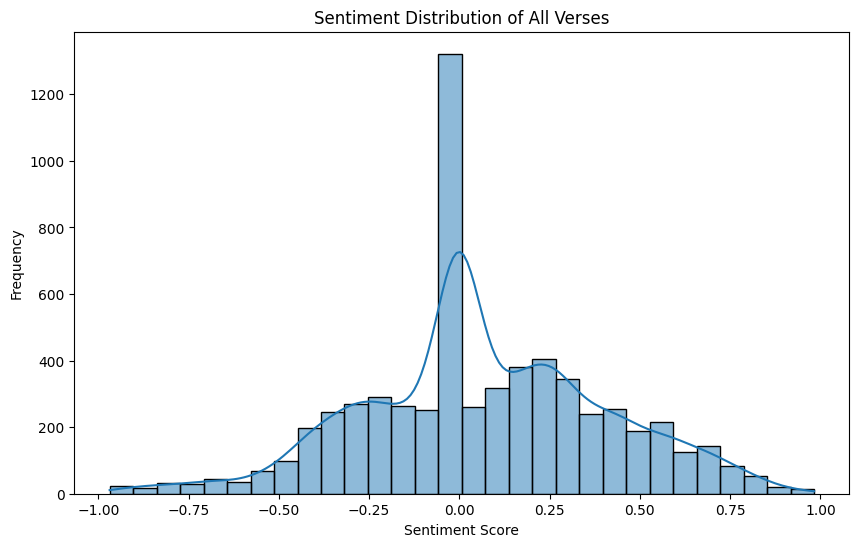

In [4]:
vader = SentimentIntensityAnalyzer()

df['vader'] = df['text'].apply(lambda x: vader.polarity_scores(x)['compound'])
df['textblob'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['sentiment_avg'] = (df['vader'] + df['textblob']) / 2

plt.figure(figsize=(10,6))
sns.histplot(df['sentiment_avg'], kde=True, bins=30)
plt.title("Sentiment Distribution of All Verses")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


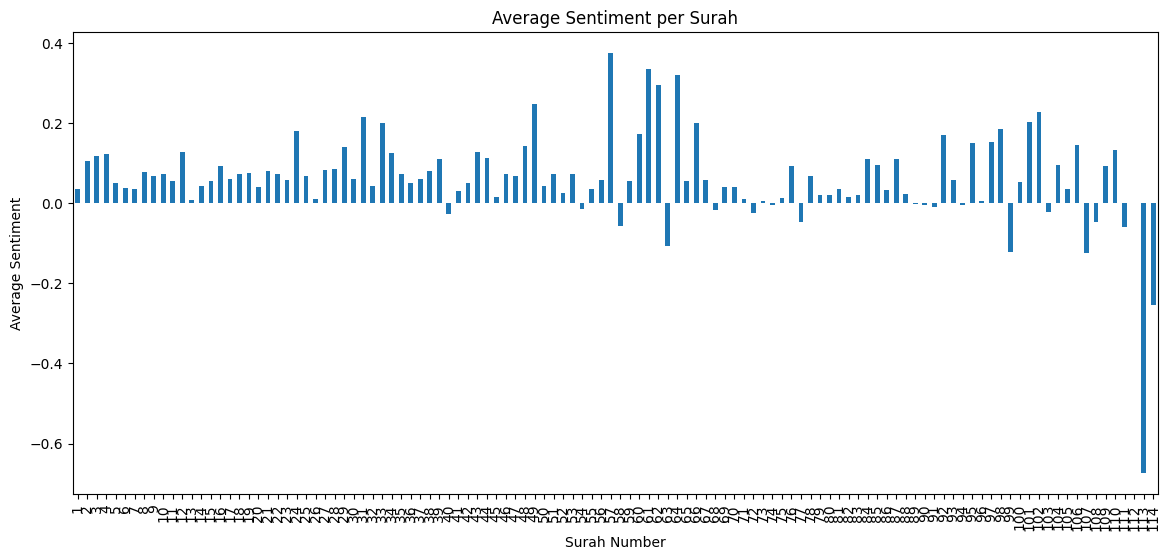

In [5]:
surah_sentiment = df.groupby('surah')['sentiment_avg'].mean()

plt.figure(figsize=(14,6))
surah_sentiment.plot(kind='bar')
plt.title("Average Sentiment per Surah")
plt.xlabel("Surah Number")
plt.ylabel("Average Sentiment")
plt.show()

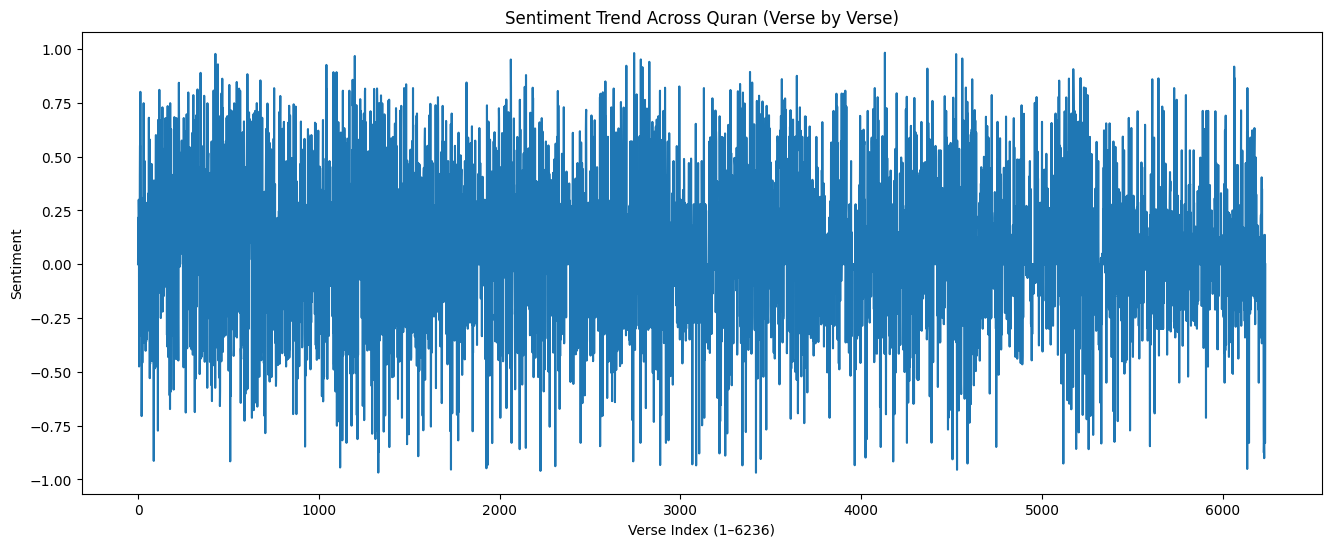

In [6]:
plt.figure(figsize=(16,6))
plt.plot(df.index, df['sentiment_avg'])
plt.title("Sentiment Trend Across Quran (Verse by Verse)")
plt.xlabel("Verse Index (1–6236)")
plt.ylabel("Sentiment")
plt.show()

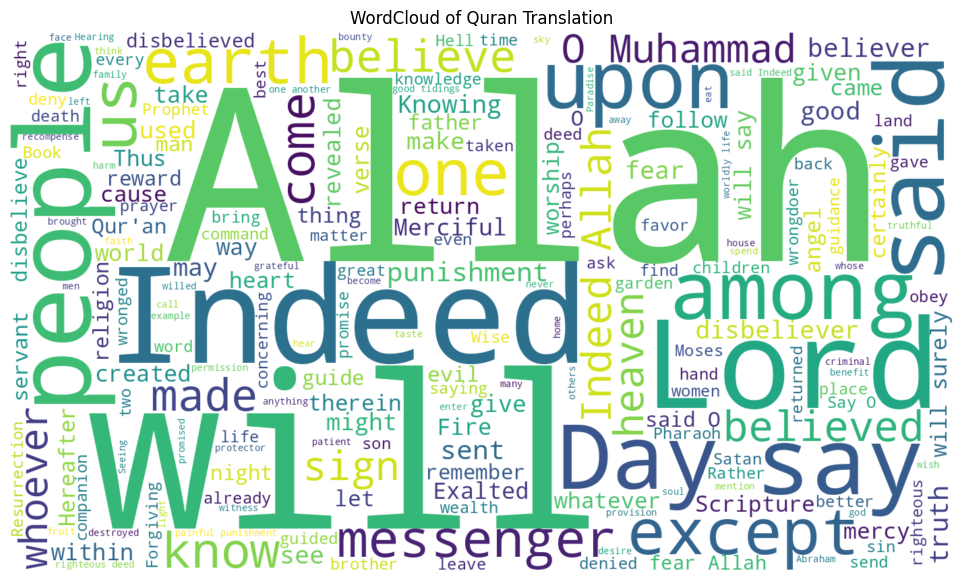

In [7]:
text_combined = " ".join(df['text'])

wc = WordCloud(width=1400, height=800, background_color="white").generate(text_combined)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Quran Translation")
plt.show()

In [ ]:
stop_words = set(stopwords.words("english"))
quran_stopwords = {"indeed", "indeed,", "say", "say,", "said", "said,", "o", "[o]", "upon", "therein", "those",
                    "these", "one", "man", "people", "men", "women", "us", "you,",  "him", "her", "we", "our", 
                    "their", "theirs","-", "—", "–", "[by]", "[in]", "[the]", "[and]", "[to]", "[for]","thing", 
                    "things", "whatever", "who", "whom", "allah", "muhammad","muhammad]","[o]","muhammad],"
                }
stop_words.update(quran_stopwords)

def preprocess(text):
    tokens = [w.lower() for w in text.split() if w.lower() not in stop_words]
    return tokens

df['tokens'] = df['text'].apply(preprocess)

dictionary = Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=7, passes=10)

topics = lda.print_topics(num_words=30)
print("Generated LDA Topics:\n")
for t in topics:
    print(t)


Generated LDA Topics:

(0, '0.015*"lord" + 0.013*"fear" + 0.011*"would" + 0.006*"favors" + 0.006*"right" + 0.006*"them]" + 0.005*"them," + 0.005*"lord," + 0.005*"me."" + 0.005*"[to" + 0.005*"love" + 0.005*"favor" + 0.005*"is]" + 0.004*"[but]" + 0.004*"allah," + 0.004*"deny?" + 0.004*"sun" + 0.004*"may" + 0.004*"made" + 0.004*""my" + 0.004*"not." + 0.004*"two" + 0.004*"feeding" + 0.004*"[who" + 0.004*"night" + 0.003*"hunger" + 0.003*"pray" + 0.003*"encourage" + 0.003*"guide" + 0.003*"free"')
(1, '0.015*"no!" + 0.012*"make" + 0.010*"surely" + 0.009*"see" + 0.008*"denied" + 0.008*"away" + 0.008*"know" + 0.008*"fire" + 0.007*"know." + 0.006*"whoever" + 0.006*"signs" + 0.006*"worship." + 0.006*"whose" + 0.006*"punishment" + 0.005*"deny" + 0.005*"good" + 0.005*"going" + 0.005*"turn" + 0.005*"it," + 0.005*"companions" + 0.004*"except" + 0.004*"city" + 0.004*"may" + 0.004*"[of" + 0.004*"disbelieved" + 0.004*"them," + 0.004*"[it" + 0.004*"day" + 0.004*"evil" + 0.004*"seen"')
(2, '0.016*"lord" +

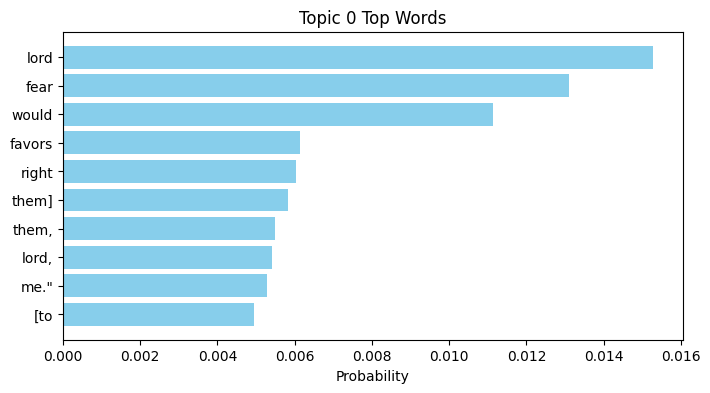

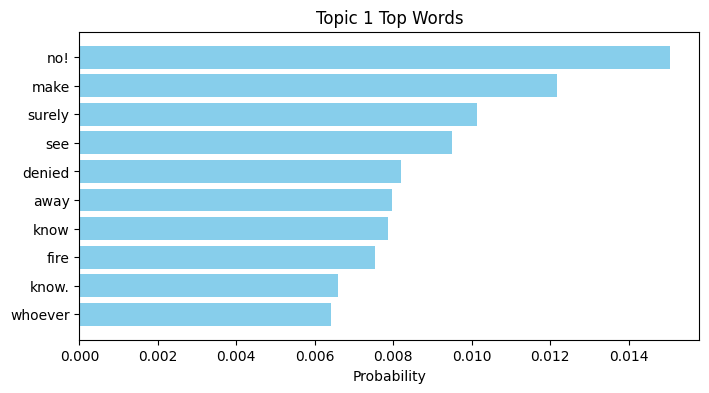

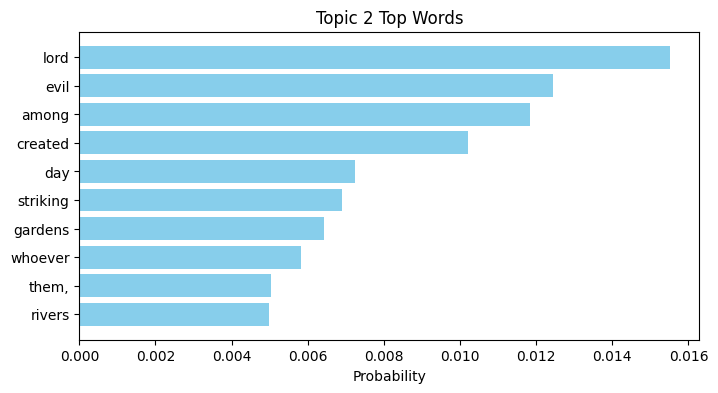

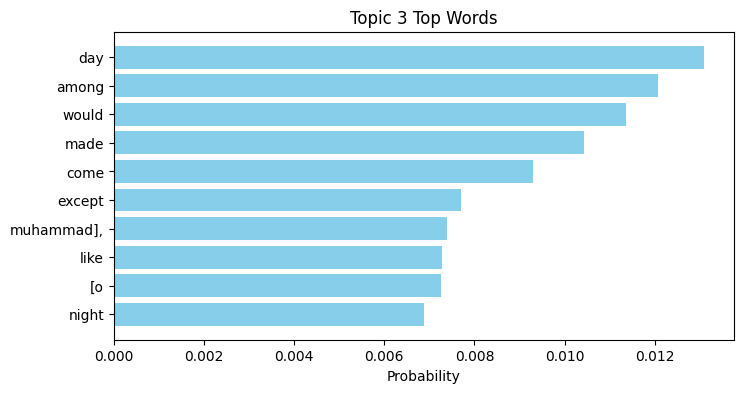

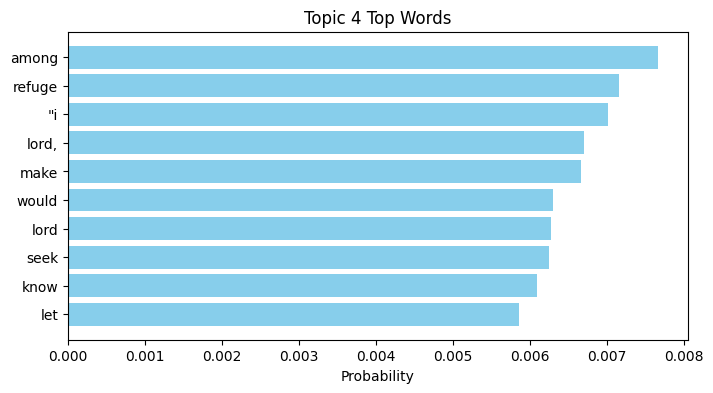

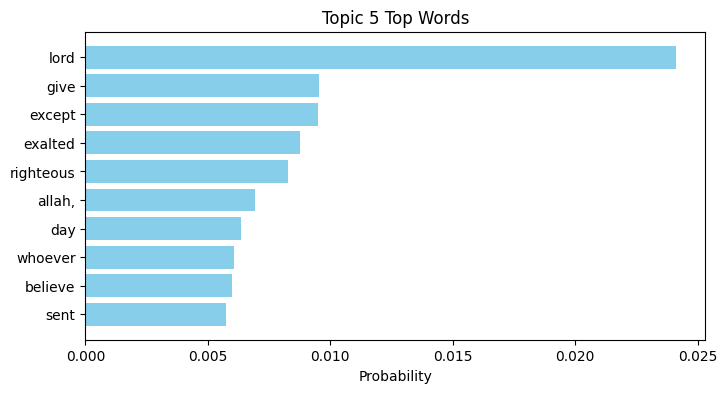

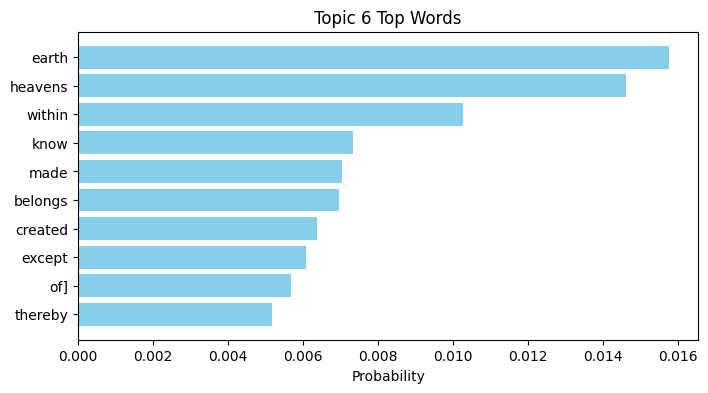

In [21]:
num_words = 10  # top words to show per topic

for topic_id in range(lda.num_topics):
    topic_terms = lda.show_topic(topic_id, topn=num_words)
    words = [w for w, _ in topic_terms]
    probs = [p for _, p in topic_terms]

    plt.figure(figsize=(8,4))
    plt.barh(words[::-1], probs[::-1], color='skyblue')
    plt.xlabel("Probability")
    plt.title(f"Topic {topic_id} Top Words")
    plt.show()

In [ ]:
topic_values = []
for i in range(len(corpus)):
    topic_values.append(sorted(lda.get_document_topics(corpus[i]), key=lambda x: -x[1])[0][0])

df['topic'] = topic_values

plt.figure(figsize=(10,6))
sns.countplot(df['topic'])
plt.title("Topic Distribution Across the Quran")
plt.xlabel("Topic Number")
plt.ylabel("Verse Count")
plt.show()

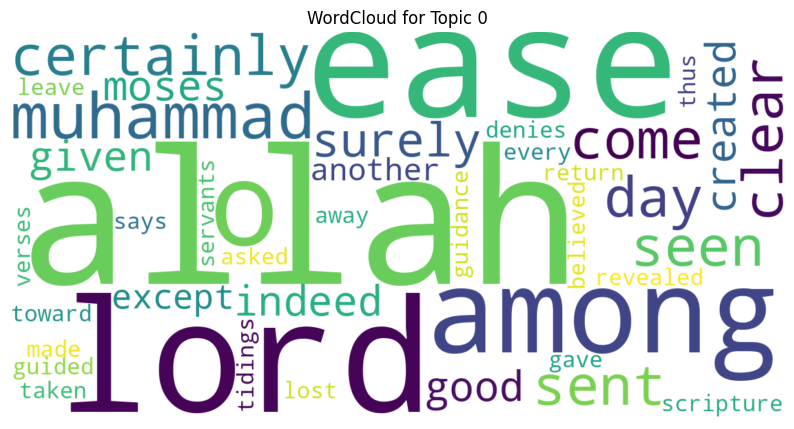

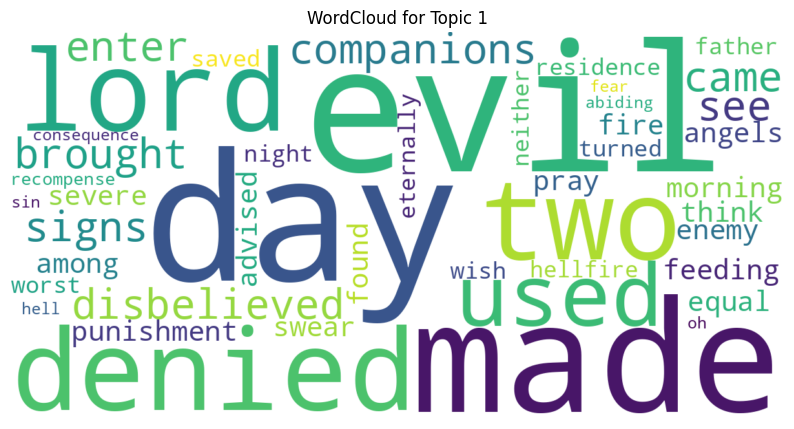

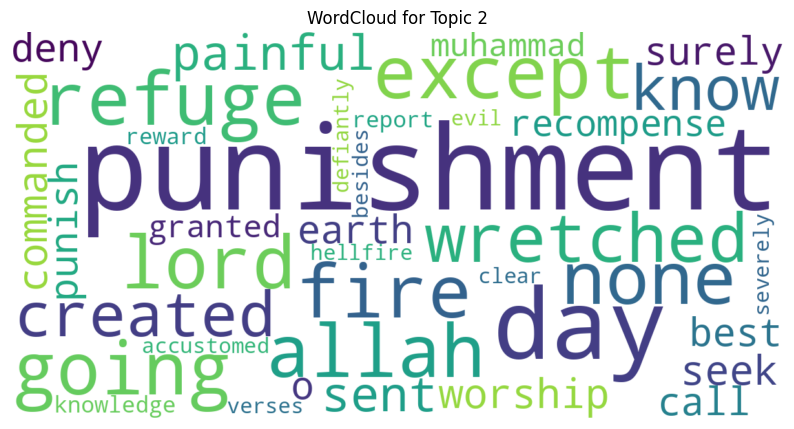

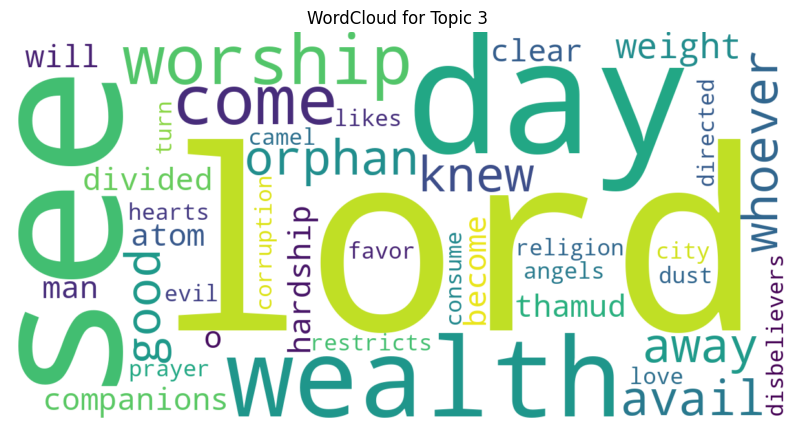

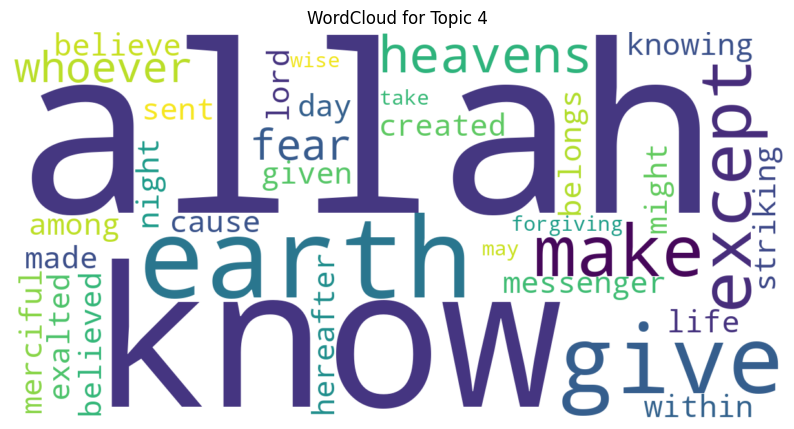

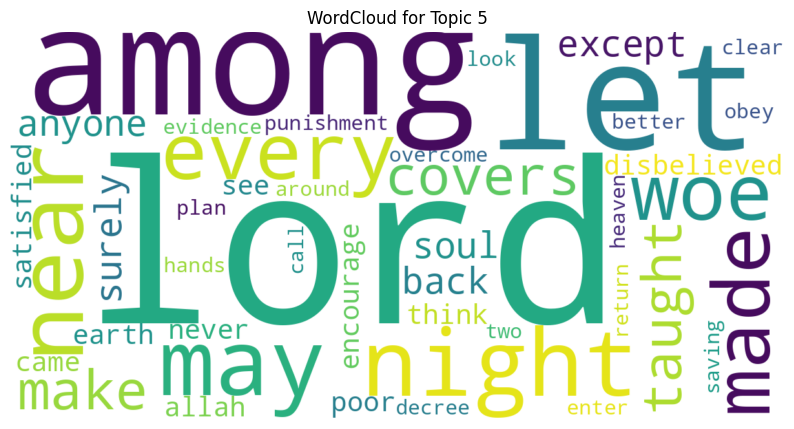

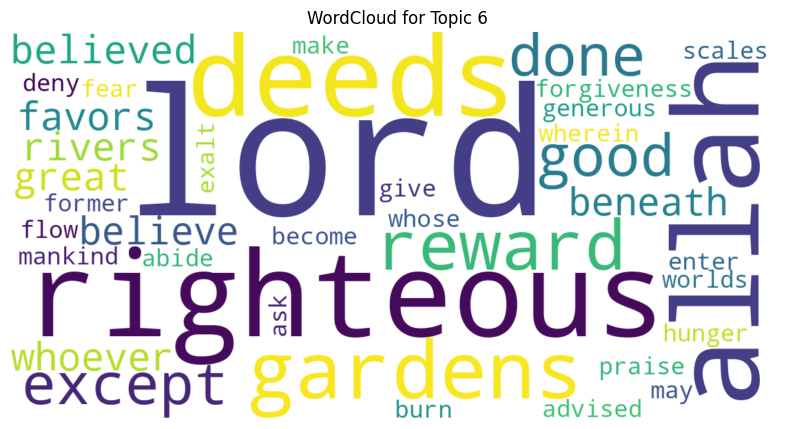

In [ ]:
for t in range(7):
    plt.figure(figsize=(10,6))
    words = lda.show_topic(t, topn=50)
    word_freq = " ".join([w for w, _ in words])
    wc_topic = WordCloud(width=1200, height=600, background_color="white").generate(word_freq)

    plt.imshow(wc_topic, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for Topic {t}")
    plt.show()

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)